# Курсовой проект: Детекция клеток малярии с использованием Faster R-CNN

Авторы: Санников Максим Витальевич, Смирнов Игорь Сергеевич


In [1]:
# 📦 Установка библиотек
!pip install -U pip
!pip install kaggle
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 138.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 66.

In [3]:
# 🔑 Настройка Kaggle API
import shutil
from pathlib import Path

Path("/root/.kaggle").mkdir(parents=True, exist_ok=True)
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# 📥 Загрузка датасета
!kaggle datasets download -d kmader/malaria-bounding-boxes
!unzip -qo malaria-bounding-boxes.zip -d malaria

Dataset URL: https://www.kaggle.com/datasets/kmader/malaria-bounding-boxes
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
100% 4.19G/4.21G [01:29<00:00, 18.4MB/s]
100% 4.21G/4.21G [01:29<00:00, 50.6MB/s]


In [5]:
# 🧱 Конвертация аннотаций в формат COCO
import os, json
from tqdm import tqdm

def convert_to_coco(source_path, image_dir, output_path):
    with open(source_path, 'r') as f:
        raw_data = json.load(f)

    coco_images = []
    coco_annotations = []
    coco_categories = {}
    category_id_counter = 1
    annotation_id = 1
    image_id = 1

    for item in tqdm(raw_data):
        image_info = item['image']
        file_name = os.path.basename(image_info['pathname'])
        width = image_info['shape']['c']
        height = image_info['shape']['r']
        coco_images.append({
            'id': image_id,
            'file_name': file_name,
            'width': width,
            'height': height
        })

        for obj in item['objects']:
            category_name = obj['category']
            if category_name not in coco_categories:
                coco_categories[category_name] = category_id_counter
                category_id_counter += 1

            cat_id = coco_categories[category_name]
            bbox = obj['bounding_box']
            xmin = bbox['minimum']['c']
            ymin = bbox['minimum']['r']
            xmax = bbox['maximum']['c']
            ymax = bbox['maximum']['r']
            width_box = xmax - xmin
            height_box = ymax - ymin

            coco_annotations.append({
                'id': annotation_id,
                'image_id': image_id,
                'category_id': cat_id,
                'bbox': [xmin, ymin, width_box, height_box],
                'area': width_box * height_box,
                'iscrowd': 0
            })
            annotation_id += 1

        image_id += 1

    coco_format = {
        'images': coco_images,
        'annotations': coco_annotations,
        'categories': [
            {'id': i, 'name': name} for name, i in coco_categories.items()
        ]
    }
    with open(output_path, 'w') as f:
        json.dump(coco_format, f, indent=4)
    print(f'✅ Сохранено: {output_path}')

In [6]:
# 🗂️ Регистрация датасета в Detectron2
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

base_path = "malaria/malaria"
image_dir = os.path.join(base_path, "images")
train_json = os.path.join(base_path, "malaria", "training.json")
test_json = os.path.join(base_path, "malaria", "test.json")
train_coco = os.path.join(base_path, "train_coco.json")
test_coco = os.path.join(base_path, "test_coco.json")

convert_to_coco(train_json, image_dir, train_coco)
convert_to_coco(test_json, image_dir, test_coco)

register_coco_instances("malaria_train", {}, train_coco, image_dir)
register_coco_instances("malaria_test", {}, test_coco, image_dir)

metadata = MetadataCatalog.get("malaria_train")
dataset_dicts = DatasetCatalog.get("malaria_train")
print(f"📦 Зарегистрировано {len(dataset_dicts)} изображений")

100%|██████████| 1208/1208 [00:00<00:00, 4012.72it/s]


✅ Сохранено: malaria/malaria/train_coco.json


100%|██████████| 120/120 [00:00<00:00, 20123.80it/s]

✅ Сохранено: malaria/malaria/test_coco.json


📦 Зарегистрировано 1208 изображений


In [8]:
# 🧠 Настройка и обучение модели Faster R-CNN
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda"
cfg.DATASETS.TRAIN = ("malaria_train",)
cfg.DATASETS.TEST = ("malaria_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(metadata.thing_classes)
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.OUTPUT_DIR = "output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/27 11:19:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 243MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/27 11:19:39 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/27 11:19:52 d2.utils.events]:  eta: 0:07:12  iter: 19  total_loss: 3.761  loss_cls: 2.128  loss_box_reg: 0.5841  loss_rpn_cls: 0.9015  loss_rpn_loc: 0.1073    time: 0.4500  last_time: 0.4487  data_time: 0.0549  last_data_time: 0.0046   lr: 4.9953e-06  max_mem: 2214M
[05/27 11:20:13 d2.utils.events]:  eta: 0:06:52  iter: 39  total_loss: 2.959  loss_cls: 1.976  loss_box_reg: 0.6566  loss_rpn_cls: 0.1714  loss_rpn_loc: 0.1107    time: 0.4333  last_time: 0.4898  data_time: 0.0079  last_data_time: 0.0250   lr: 9.9902e-06  max_mem: 2400M
[05/27 11:20:22 d2.utils.events]:  eta: 0:06:44  iter: 59  total_loss: 2.584  loss_cls: 1.768  loss_box_reg: 0.6753  loss_rpn_cls: 0.04211  loss_rpn_loc: 0.09491    time: 0.4338  last_time: 0.4734  data_time: 0.0190  last_data_time: 0.0060   lr: 1.4985e-05  max_mem: 2454M
[05/27 11:20:31 d2.utils.events]:  eta: 0:06:38  iter: 79  total_loss: 2.252  loss_cls: 1.475  loss_box_reg: 0.6223  loss_rpn_cls: 0.03733  loss_rpn_loc: 0.09526    time: 0.4403  last_t

In [10]:
# 📊 Оценка модели на тестовом наборе
import os
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo

register_coco_instances("malaria_test", {}, "malaria/malaria/test_coco.json", "malaria/malaria/images")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
cfg.MODEL.WEIGHTS = os.path.join("output", "model_final.pth")
cfg.MODEL.DEVICE = "cuda"
cfg.DATASETS.TEST = ("malaria_test", )


evaluator = COCOEvaluator("malaria_test", cfg, False, output_dir="./output_malaria")
val_loader = build_detection_test_loader(cfg, "malaria_test")
inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)

WARNING [05/27 11:34:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/27 11:34:41 d2.data.datasets.coco]: Loaded 120 images in COCO format from malaria/malaria/test_coco.json
[05/27 11:34:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/27 11:34:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/27 11:34:41 d2.data.common]: Serializing 120 elements to byte tensors and concatenating them all ...
[05/27 11:34:41 d2.data.common]: Serialized dataset takes 0.21 MiB


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[05/27 11:34:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...
[05/27 11:34:42 d2.evaluation.evaluator]: Start inference on 120 batches
[05/27 11:34:44 d2.evaluation.evaluator]: Inference done 11/120. Dataloading: 0.0043 s/iter. Inference: 0.1240 s/iter. Eval: 0.0004 s/iter. Total: 0.1286 s/iter. ETA=0:00:14
[05/27 11:34:49 d2.evaluation.evaluator]: Inference done 52/120. Dataloading: 0.0068 s/iter. Inference: 0.1155 s/iter. Eval: 0.0004 s/iter. Total: 0.1229 s/iter. ETA=0:00:08
[05/27 11:34:54 d2.evaluation.evaluator]: Inference done 86/120. Dataloading: 0.0083 s/iter. Inference: 0.1238 s/iter. Eval: 0.0008 s/iter. Total: 0.1332 s/iter. ETA=0:00:04
[05/27 11:34:59 d2.evaluation.evaluator]: Total inference time: 0:00:15.034623 (0.130736 s / iter per device, on 1 devices)
[05/27 11:34:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:13 (0.121633 s / iter per device, on 1 devices)
[05/27 11:34:59 d2.evaluation.coco

OrderedDict([('bbox',
              {'AP': 12.636743071625675,
               'AP50': 16.125753142676142,
               'AP75': 15.033001656933026,
               'APs': nan,
               'APm': 22.20271574918009,
               'APl': 12.660628151472498,
               'AP-red blood cell': 75.17689407331841,
               'AP-trophozoite': 0.6435643564356436,
               'AP-ring': 0.0,
               'AP-schizont': 0.0,
               'AP-difficult': 0.0,
               'AP-gametocyte': 0.0})])

[05/27 11:38:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...
[05/27 11:38:22 d2.data.datasets.coco]: Loaded 120 images in COCO format from malaria/malaria/test_coco.json
[05/27 11:38:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/27 11:38:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/27 11:38:23 d2.data.common]: Serializing 120 elements to byte tensors and concatenating them all ...
[05/27 11:38:23 d2.data.common]: Serialized dataset takes 0.21 MiB


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


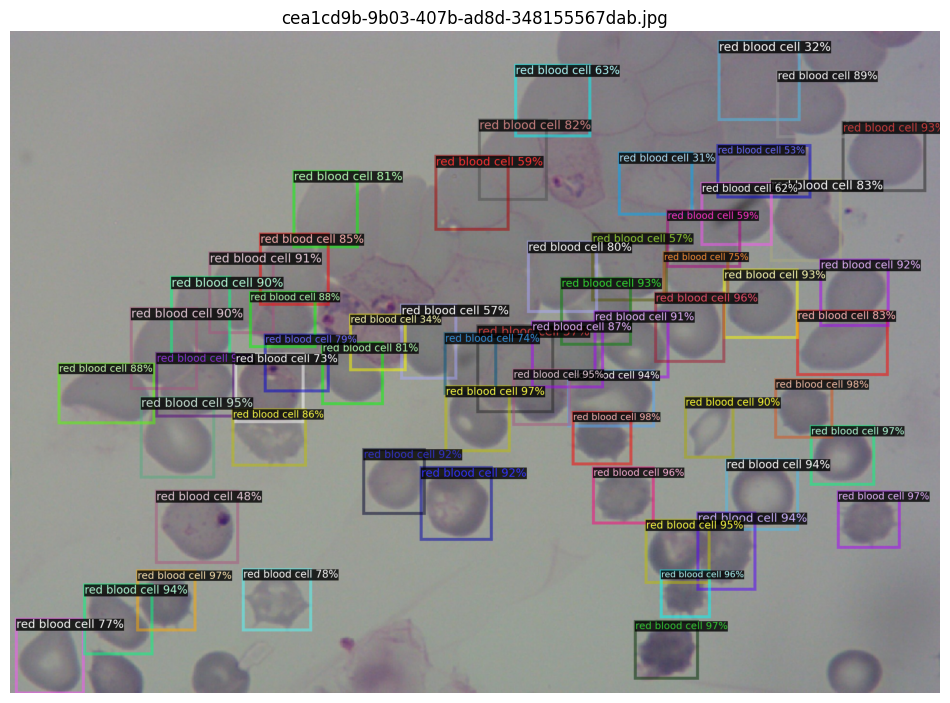

In [13]:
# 🖼️ Визуализация случайного изображения
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

predictor = DefaultPredictor(cfg)
dataset_dicts = build_detection_test_loader(cfg, "malaria_test").dataset

sample = random.choice(dataset_dicts)
img_path = sample["file_name"]
image = cv2.imread(img_path)
outputs = predictor(image)

v = Visualizer(image[:, :, ::-1], MetadataCatalog.get("malaria_test"), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(12, 12))
plt.imshow(out.get_image())
plt.axis("off")
plt.title(os.path.basename(img_path))
plt.show()